<a href="https://colab.research.google.com/github/polymoe/datascientest/blob/main/3_Age_%26_Gender_detection_corrig%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/train/logo_datascientest.png" style="height:150px;center"></center>

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Deep-Learning - Modules complémentaires</h1></center>
<center><h2>Détection du genre et de l'age d'une personne avec son visage</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


Le but de cet exercice est de s'exercer à créer des modèles à plusieurs sorties.

 Nous allons travailler avec la base de données **```age_gender.csv```**. Cette base contient des images de visages, ainsi que le genre et l'age de la personne en question.

 Notez que les images sont stockées dans le DataFrame sous forme de string facilement convertibles en tableau ```numpy``` de taille 48*48. Chaque élément du tableau représente la valeur du pixel de l'image (l'image est donc en noir et blanc).

> La structure de l'exercice est la suivante : 
>> I - [Préparation du dataset](#preparation)
>>
>>
>> II - [Classification du genre et prédiction de l'âge avec un unique modèle](#model)
>>
>>
>> III - [Test en temps réel](#test)

- Exécuter la cellule ci-dessous pour importer les modules nécessaires à l'exercice.

In [ ]:
!wget https://assets-datascientest.s3-eu-west-1.amazonaws.com/datasets/age_gender.zip
!unzip age_gender.zip

--2021-09-03 12:30:55--  https://assets-datascientest.s3-eu-west-1.amazonaws.com/datasets/age_gender.zip
Resolving assets-datascientest.s3-eu-west-1.amazonaws.com (assets-datascientest.s3-eu-west-1.amazonaws.com)... 52.218.29.72
Connecting to assets-datascientest.s3-eu-west-1.amazonaws.com (assets-datascientest.s3-eu-west-1.amazonaws.com)|52.218.29.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66099409 (63M) [application/zip]
Saving to: ‘age_gender.zip’

age_gender.zip      100%[===================>]  63.04M  11.5MB/s    in 7.2s    

2021-09-03 12:31:04 (8.74 MB/s) - ‘age_gender.zip’ saved [66099409/66099409]

Archive:  age_gender.zip
  inflating: age_gender.csv          


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# I - <a name="preparation"></a> Préparation du dataset

- (a) Exécuter la cellule suivante pour importer le jeu de données dans un DataFrame ```df``` et convertir la colonne ```pixels``` en tableau ```numpy``` redimensionné.

In [ ]:
df = pd.read_csv('age_gender.csv', sep=';')
df['pixels'] = df['pixels'].apply(lambda x : np.array(x.split()).astype(np.int16).reshape(48, 48, 1))

- (b) Afficher la shape de ```df``` ainsi que ses 5 premières lignes.

In [ ]:
print("Nombre de lignes dans le dataset : {}".format(df.shape[0]))
print("Nombre de colonnes dans le dataset : {}".format(df.shape[1]))

df.head()

Nombre de lignes dans le dataset : 23705
Nombre de colonnes dans le dataset : 3


,age,gender,pixels
0,1,0,"[[[129], [128], [128], [126], [127], [130], [1..."
1,1,0,"[[[164], [74], [111], [168], [169], [171], [17..."
2,1,0,"[[[67], [70], [71], [70], [69], [67], [70], [7..."
3,1,0,"[[[193], [197], [198], [200], [199], [200], [2..."
4,1,0,"[[[202], [205], [209], [210], [209], [209], [2..."


- (c) Exécuter les cellules suivantes pour créer un générateur personnalisé à notre problème.
> - Nous sommes obligés de créer ce type de générateur pour des modèles à plusieurs sorties comme ici.
>
>
> - Le générateur n'applique pas de transformation aux images, simplement un scaling.
>
> - Pas besoin de reshape les données, cette étape a déjà été faite lors de l'importation de ```df```.

In [ ]:
class DataGenerator():
    def __init__(self, df):
        self.df = df        


    def generate_splits(self):     
        '''reproduction de la fonction train_test_split'''                           
        permut = np.random.permutation(len(self.df))          # mélange des indices

        # équivalent de data_without_test, data_test = train_test_split(data, test_size=0.2)
        train_up_to = int(len(self.df)*0.8)
        indices_without_test = permut[:train_up_to]           
        test_indices = permut[train_up_to:]              
        
        # équivalent de data_train, data_validation = train_test_split(data_without_test, test_size=0.2)
        train_up_to = int(train_up_to*0.8)
        train_indices = indices_without_test[:train_up_to]
        valid_indices = indices_without_test[train_up_to:] 

        return train_indices, valid_indices, test_indices     # on retourne les indices


    def generate_images(self, indices, is_training, batch_size=32):  
        '''utilisé pour générer des batchs avec des images lors de l'entraînement/test/validation de notre modèle Keras
           par exemple, on aura "indices=train_indices, is_training=True" pour un générateur d'entraînement
                                "indices=test_indices, is_training=False" pour un générateur de test'''
        max_age = self.df['age'].max()                                           # max_age sert à scaler les ages entre 0 et 1
        files, genders, ages = [], [], []                                        # on initialise des listes vides pour contenir ce que renverra le générateur
        while True:
            for i in indices:                                                    # on parcours les indices de la liste prise en argument
                person = self.df.iloc[i]                                         # on repère la personne d'indice i

                files.append((person['pixels']/255))                             # on ajoute l'image de la personne d'indice i(pixels scalés entre 0 et 1)
                genders.append(person['gender'])                                 # on ajoute le genre de la personne d'indice i à la liste "genders"
                ages.append(person['age']/max_age)                               # on ajoute l'age scalé de la personne d'indice i

                if len(files) >= batch_size:                                     # dès qu'on a atteind la taille de batch souhaitée
                    yield np.array(files), [np.array(genders), np.array(ages)]   # on renvoie les données
                    # assurez-vous de vous souvenir de l'ordre des sorties car nous devrons définir notre modèle en conséquence
                    files, genders, ages = [], [], []                            # on réinitialise les listes
            # pour les prédictions, il faut s'arrêter après avoir parcouru toutes les données une fois
            if not is_training:
                break

In [ ]:
data_generator = DataGenerator(df)
train_indices, valid_indices, test_indices = data_generator.generate_splits() 

In [ ]:
batch_size = 64

training_data = data_generator.generate_images(train_indices, is_training=True, batch_size=batch_size)
valid_data = data_generator.generate_images(valid_indices, is_training=True, batch_size=batch_size)
test_data = data_generator.generate_images(test_indices, is_training=False, batch_size=batch_size)

# II - <a name="model"></a> Classification du genre et prédiction de l'âge avec un unique modèle

Voici un template qui vous aidera à créer un modèle à plusieurs sorties :

```py
class MultiOutputModel():
    def hidden_layers(self, inputs):
        x = Conv2D(...)(inputs)
        x = MaxPooling2D(...)(x)
        ...
        x = Dropout(...)(x)
        return x
    def branch_1(self, inputs):
        x = self.hidden_layers(inputs)
        x = ...(x)
        ...
        x = Dense(units=..., activation=..., name='output_1')(x)
        return x
    def branch_2(self, inputs):
        x = self.hidden_layers(inputs)
        x = ...(x)
        ...
        x = Dense(units=..., activation=..., name='output_2')(x)
        return x
    def create_model(self, input_shape):
        inputs = Input(shape=input_shape)
        branch_1 = self.branch_1(inputs)
        branch_2 = self.branch_2(inputs)
        model = Model(inputs=inputs, outputs=[branch_1, branch_2])
        return model
        
model = MultiOutputModel().create_model(input_shape)

loss = {'output_1': '...', 'output_2': '...'}
metrics = {'output_1': '...', 'output_2': '...'}
model.compile(optimizer='...', loss=loss, metrics=metrics)
```

- (a) Instancier un réseau de neurones à deux sorties (```gender_output``` et ```age_output```) de l'architecture de votre choix.
> Attention aux dernières couches de vos branches, il y a une classification et une régression à faire.

- (b) Compiler le modèle avec des fonctions de perte et des métriques appropriées.

- (c) Entraîner le modèle avec les générateurs d'entraînement et de validation définis précédemment. On pourra également définir des callbacks.

- (d) Evaluer le modèle avec le générateur de test défini précédemment.

- (e) Effectuer une prédiction à partir des données de test.

- (f) Afficher des prédictions avec la fonction ```imshow```.

In [ ]:
class MultiOutputModel():
    def hidden_layers(self, inputs):
        x = Conv2D(filters=30, kernel_size=(5, 5), padding='valid', activation='relu')(inputs)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(rate=0.25)(x)
        return x
    def gender_branch(self, inputs):
        x = self.hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(units=64, activation='relu')(x)
        x = Dropout(rate=0.2)(x)
        x = Dense(units=1, activation='sigmoid', name='gender_output')(x)
        return x
    def age_branch(self, inputs):   
        x = self.hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(units=64, activation='relu')(x)
        x = Dropout(rate=0.2)(x)
        x = Dense(units=1, activation='linear', name='age_output')(x)
        return x
    def create_model(self, input_shape):
        inputs = Input(shape=input_shape)
        gender_branch = self.gender_branch(inputs)
        age_branch = self.age_branch(inputs)
        model = Model(inputs=inputs, outputs=[gender_branch, age_branch])
        return model
        
input_shape = (48,48,1)
model = MultiOutputModel().create_model(input_shape)

In [ ]:
loss = {'gender_output': 'binary_crossentropy', 'age_output': 'mse'}
metrics = {'gender_output': 'accuracy', 'age_output': 'mae'}

model.compile(optimizer='adam', loss=loss, metrics=metrics)

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=12,
                                         mode='min',
                                         restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         patience=8,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min')

In [ ]:
history = model.fit_generator(training_data,
                              steps_per_epoch=len(train_indices)//batch_size,
                              epochs=100,
                              validation_data=valid_data,
                              validation_steps=len(valid_indices)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
237/237 [==============================] - 38s 34ms/step - loss: 0.5410 - gender_output_loss: 0.5148 - age_output_loss: 0.0261 - gender_output_accuracy: 0.7456 - age_output_mae: 0.1223 - val_loss: 0.4221 - val_gender_output_loss: 0.4050 - val_age_output_loss: 0.0171 - val_gender_output_accuracy: 0.8183 - val_age_output_mae: 0.1036
Epoch 2/100
237/237 [==============================] - 8s 33ms/step - loss: 0.4048 - gender_output_loss: 0.3885 - age_output_loss: 0.0163 - gender_output_accuracy: 0.8259 - age_output_mae: 0.0968 - val_loss: 0.3643 - val_gender_output_loss: 0.3512 - val_age_output_loss: 0.0131 - val_gender_output_accuracy: 0.8549 - val_age_output_mae: 0.0869
Epoch 3/100
237/237 [==============================] - 8s 32ms/step - loss: 0.3664 - gender_output_loss: 0.3526 - age_output_loss: 0.0138 - gender_output_accuracy: 0.8402 - age_output_mae: 0.0887 - val_loss: 0.3359 - val_gender_output_loss: 0.3244 - val_age_output_loss: 0.0115 - val_gender_output_accuracy: 0.8

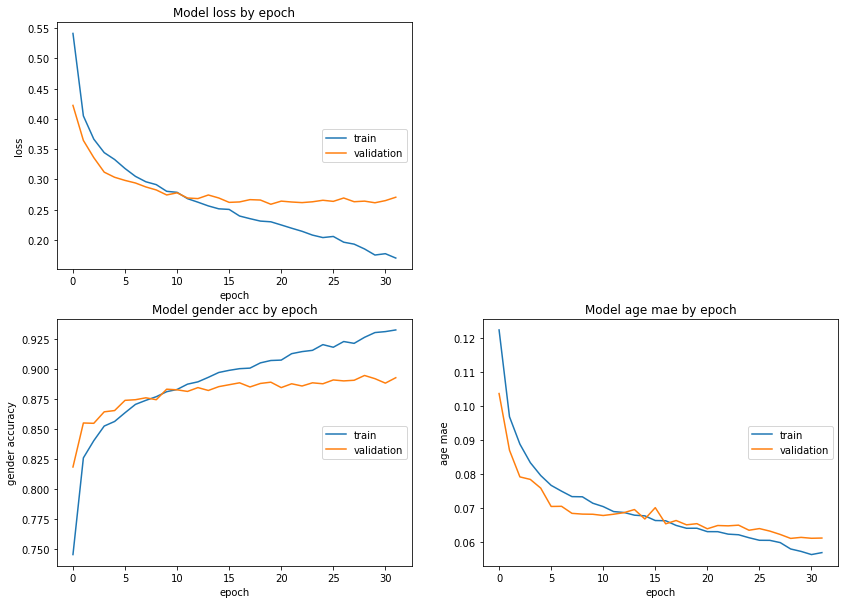

In [ ]:
plt.figure(figsize=(14,10))
plt.subplot(221)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(223)
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Model gender acc by epoch')
plt.ylabel('gender accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(224)
plt.plot(history.history['age_output_mae'])
plt.plot(history.history['val_age_output_mae'])
plt.title('Model age mae by epoch')
plt.ylabel('age mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right');

In [ ]:
model.evaluate(test_data)

74/74 [==============================] - 2s 25ms/step - loss: 0.2468 - gender_output_loss: 0.2389 - age_output_loss: 0.0078 - gender_output_accuracy: 0.8961 - age_output_mae: 0.0645


[0.2467508614063263,
 0.2389049530029297,
 0.007845885120332241,
 0.8961148858070374,
 0.06445536017417908]

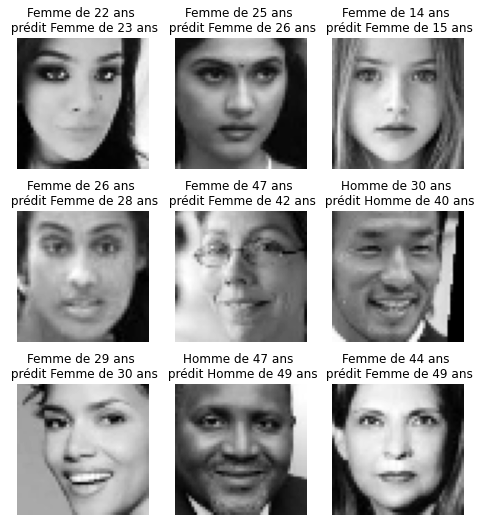

In [ ]:
gender_dict = {0 : 'Homme', 1 : 'Femme'}
age_max = df['age'].max()

fig, axs = plt.subplots(3, 3, figsize=(8, 9))

for row in range(3):
  for col in range(3):
    i = np.random.randint(len(test_indices))
    pred = model.predict((df['pixels'][test_indices[i]]/255).reshape(1, 48, 48, 1))
    axs[row, col].imshow(df['pixels'][test_indices[i]].reshape((48, 48)), cmap="gray")
    axs[row, col].axis('off')
    axs[row, col].set_title('{} de {} ans \n prédit {} de {} ans'\
                            .format(gender_dict[df['gender'][test_indices[i]]], df['age'][test_indices[i]],\
                                    gender_dict[pred[0][0][0].round()], max(int(round(pred[1][0][0]*age_max)), 0)))

# III - <a name="test"></a> Test en temps réel

- (a) Lancer les cellules suivantes pour tester votre modèle en direct sur votre webcam.

In [ ]:
import cv2
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import html
import time

def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

def bbox_to_bytes(bbox_array):
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0 
gender_dict = {0 : 'Homme', 1 : 'Femme'}
age_max = df['age'].max()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    img = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,255,255),2)
      face_img=gray[y:y+w,x:x+w]
      resized=cv2.resize(face_img,(48,48))
      reshaped=np.reshape(resized,(1, 48,48,1))
      pred = model.predict(reshaped/255)
      cv2.putText(bbox_array, gender_dict[pred[0][0][0].round()] + " de " + str(int(round(pred[1][0][0]*age_max))) + " ans", (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>